In [1]:
import pandas as pd
import numpy as np
from scipy.stats import nbinom
from pathlib import Path


import matplotlib.pyplot as plt

In [2]:
# Read data

mun_new = list(Path('/opt/storage/refined/aesop/visualization/')
               .glob('aesop_*_mun_new.parquet'))

aesop_mun_new = max(mun_new, key=lambda x: x.stat().st_ctime)

df = pd.read_parquet(aesop_mun_new)

ValueError: max() arg is an empty sequence

In [6]:
def calculate_expected_cases_nb(df, cases = 'atend_ivas', min_years=2, fallback_dispersion=1000):
    """
    Estimate expected cases per epiweek using historical data and Negative Binomial model.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Must contain columns: ['year', 'epiweek', 'cases']
    min_years : int
        Minimum number of past years needed to estimate NB parameters. Otherwise, uses Poisson approx.
    fallback_dispersion : float
        Dispersion (r) value to use if variance <= mean (e.g., near-Poisson case)

    Returns:
    --------
    pd.DataFrame
        Columns: ['epiweek', 'expected_cases', 'ci_lower_95', 'ci_upper_95', 'n_years']
    """
    results = []

    for week in range(1, 54):  # Support epiweek 53 in some years
        weekly_data = df[df['epiweek'] == week][cases].dropna()

        n_years = weekly_data.shape[0]
        if n_years < min_years:
            continue  # Skip if not enough data

        mu = weekly_data.mean()
        var = weekly_data.var(ddof=1)

        # Estimate dispersion parameter r
        if var > mu:
            r = mu**2 / (var - mu)
        else:
            r = fallback_dispersion  # Use large r to approximate Poisson

        p = r / (r + mu)

        # 95% Confidence Interval
        ci_lower = nbinom.ppf(0.025, r, p)
        ci_upper = nbinom.ppf(0.975, r, p)

        results.append({
            'epiweek': week,
            'expected_cases': mu,
            'ci_lower_95': ci_lower,
            'ci_upper_95': ci_upper,
            'n_years': n_years
        })

    return pd.DataFrame(results)


In [7]:
def run_exp(data, series ='atend_ivas', year_min=2022, year_max=2024, year_actual=2025):
    """
    Compute expected values for a given variable using past years,
    merge with actual year data by year-week key, and return merged results.

    Parameters:
    - data: DataFrame containing at least ['co_ibge', 'epiyear', 'epiweek', 'year_week', <cases>]
    - cases: str, name of the variable (e.g., 'atend_ivas', 'atend_arbov')
    - year_min/year_max: bounds for the historical data
    - year_actual: current year to apply expectations to

    Returns:
    - List of merged DataFrames per municipality
    """
    lst = []

    for code in data['co_ibge'].unique():
        # Filter once
        set_muni = data[data['co_ibge'] == code]
        set_muni_previous = set_muni[(set_muni['epiyear'] >= year_min) & (set_muni['epiyear'] <= year_max)].copy()

        # Calculate expected values for the given variable
        expected_df = calculate_expected_cases_nb(set_muni_previous, cases = series)
        expected_df['epiyear'] = year_actual
        

        # Merge actual data with expected values
        merged = set_muni.merge(expected_df, on=['epiyear','epiweek'], how='left')

        # Rename confidence intervals and expected cases with suffix from `cases`
        merged = merged.rename(columns={
            'expected_cases': f'expected_{series}',
            'ci_lower_95': f'ci_lower_95_{series}',
            'ci_upper_95': f'ci_upper_95_{series}',
        })

        # Clean columns
        merged = merged.drop(columns=['n_years', 'epiweek_y', 'epiyear_y'], errors='ignore')
        merged = merged.rename(columns={'epiweek_x': 'epiweek', 'epiyear_x': 'epiyear'})

        lst.append(merged)

    return lst



In [8]:
# Run model for Ivas

## 2025
df_results = run_exp(df, series='atend_ivas', year_min=2022, year_max=2024, year_actual=2025)

df_final = pd.concat(df_results, ignore_index=True)

df_final = df_final.rename(columns= {'expected_atend_ivas': 'expected_atend_ivas_2025',
                                    'ci_lower_95_atend_ivas':'ci_lower_95_atend_ivas_2025',
                                    'ci_upper_95_atend_ivas':'ci_upper_95_atend_ivas_2025'})

## 2024

df_results2 = run_exp(df_final, series='atend_ivas', year_min=2022, year_max=2023, year_actual=2024)

df_final2 = pd.concat(df_results2, ignore_index =True)

df_final2 = df_final2.assign(expected_atend_ivas = (df_final2.expected_atend_ivas.fillna(0) + df_final2.expected_atend_ivas_2025.fillna(0)).astype(int),
                             ci_lower_95_atend_ivas = (df_final2.ci_lower_95_atend_ivas.fillna(0) + df_final2.ci_lower_95_atend_ivas_2025.fillna(0)).astype(int),
                             ci_upper_95_atend_ivas = (df_final2.ci_upper_95_atend_ivas.fillna(0) + df_final2.ci_upper_95_atend_ivas_2025.fillna(0)).astype(int))

df_final2 = df_final2.assign(exc_atend_ivas = ((df_final2.atend_ivas - df_final2.expected_atend_ivas)*100/df_final2.atend_ivas).clip(lower=0))



In [9]:
# Run model for arbov

## 2025
df_results = run_exp(df_final2, series='atend_arbov', year_min=2022, year_max=2024, year_actual=2025)

df_final = pd.concat(df_results, ignore_index=True)

df_final = df_final.rename(columns= {'expected_atend_arbov': 'expected_atend_arbov_2025',
                                    'ci_lower_95_atend_arbov':'ci_lower_95_atend_arbov_2025',
                                    'ci_upper_95_atend_arbov':'ci_upper_95_atend_arbov_2025'})

## 2024 
df_results2 = run_exp(df_final, series='atend_arbov', year_min=2022, year_max=2023, year_actual=2024)

df_final2 = pd.concat(df_results2, ignore_index =True)

df_final2 = df_final2.assign(expected_atend_arbov = (df_final2.expected_atend_arbov.fillna(0) + df_final2.expected_atend_arbov_2025.fillna(0)).astype(int),
                             ci_lower_95_atend_arbov = (df_final2.ci_lower_95_atend_arbov.fillna(0) + df_final2.ci_lower_95_atend_arbov_2025.fillna(0)).astype(int),
                             ci_upper_95_atend_arbov = (df_final2.ci_upper_95_atend_arbov.fillna(0) + df_final2.ci_upper_95_atend_arbov_2025.fillna(0)).astype(int))

df_final2 = df_final2.assign(exc_atend_arbov = ((df_final2.atend_arbov - df_final2.expected_atend_arbov)*100/df_final2.atend_arbov).clip(lower=0))

In [10]:
df_final2 = df_final2.drop(columns=['expected_atend_ivas_2025','ci_lower_95_atend_ivas_2025', 'ci_upper_95_atend_ivas_2025',
                                   'expected_atend_arbov_2025','ci_lower_95_atend_arbov_2025', 'ci_upper_95_atend_arbov_2025'])

In [11]:
df_final2 = df_final2.assign(exc_atend_ivas = round(df_final2.exc_atend_ivas.fillna(0),2),
                            exc_atend_arbov = round(df_final2.exc_atend_arbov.fillna(0),2) ) 

In [50]:
#df_final2.columns.to_list()

In [49]:
#df_final2[['year_week', 'exc_atend_ivas', 'exc_atend_arbov']]

In [12]:
df_final2[df_final2.nm_municipio == 'Rio de Janeiro']#.nm_municipio.unique()

,co_ibge,epiyear,epiweek,atend_totais,atend_ivas,atend_arbov,year_week,co_uf,nm_uf,co_ibge7,...,exc_ml_ivas,sinal_ml_ivas_y,expected_atend_ivas,ci_lower_95_atend_ivas,ci_upper_95_atend_ivas,exc_atend_ivas,expected_atend_arbov,ci_lower_95_atend_arbov,ci_upper_95_atend_arbov,exc_atend_arbov
1445932,330455,2017,1,157092,5101,434,2017-01,33,Rio de Janeiro,3304557,...,0.0,NaN,0,0,0,100.00,0,0,0,100.0
1445933,330455,2017,2,177221,5080,439,2017-02,33,Rio de Janeiro,3304557,...,0.0,NaN,0,0,0,100.00,0,0,0,100.0
1445934,330455,2017,3,152645,4120,443,2017-03,33,Rio de Janeiro,3304557,...,0.0,NaN,0,0,0,100.00,0,0,0,100.0
1445935,330455,2017,4,195141,4911,607,2017-04,33,Rio de Janeiro,3304557,...,0.0,NaN,0,0,0,100.00,0,0,0,100.0
1445936,330455,2017,5,192028,4628,587,2017-05,33,Rio de Janeiro,3304557,...,0.0,NaN,0,0,0,100.00,0,0,0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446373,330455,2025,25,85987,10688,21,2025-25,33,Rio de Janeiro,3304557,...,8015.0,NaN,13428,4251,27788,0.00,1621,72,5498,0.0
1446374,330455,2025,26,135585,15292,30,2025-26,33,Rio de Janeiro,3304557,...,12453.0,NaN,12983,4887,24963,15.10,1573,49,5637,0.0
1446375,330455,2025,27,123265,13406,28,2025-27,33,Rio de Janeiro,3304557,...,11573.0,NaN,14158,1836,38787,0.00,1359,95,4258,0.0
1446376,330455,2025,28,116714,11919,16,2025-28,33,Rio de Janeiro,3304557,...,10511.0,NaN,11438,2275,27854,4.04,1259,70,4111,0.0


In [13]:
code = 330455

set_muni = df_final2[df_final2.co_ibge == code][['co_ibge','epidemi_cal_start','year_week','atend_ivas','atend_arbov','sinal_ens_ivas',
                                                 'sinal_ens_arbov',
                                                 'expected_atend_ivas','ci_lower_95_atend_ivas','ci_upper_95_atend_ivas','exc_atend_ivas',
                                                 'expected_atend_arbov','ci_lower_95_atend_arbov','ci_upper_95_atend_arbov','exc_atend_arbov']][-81:]

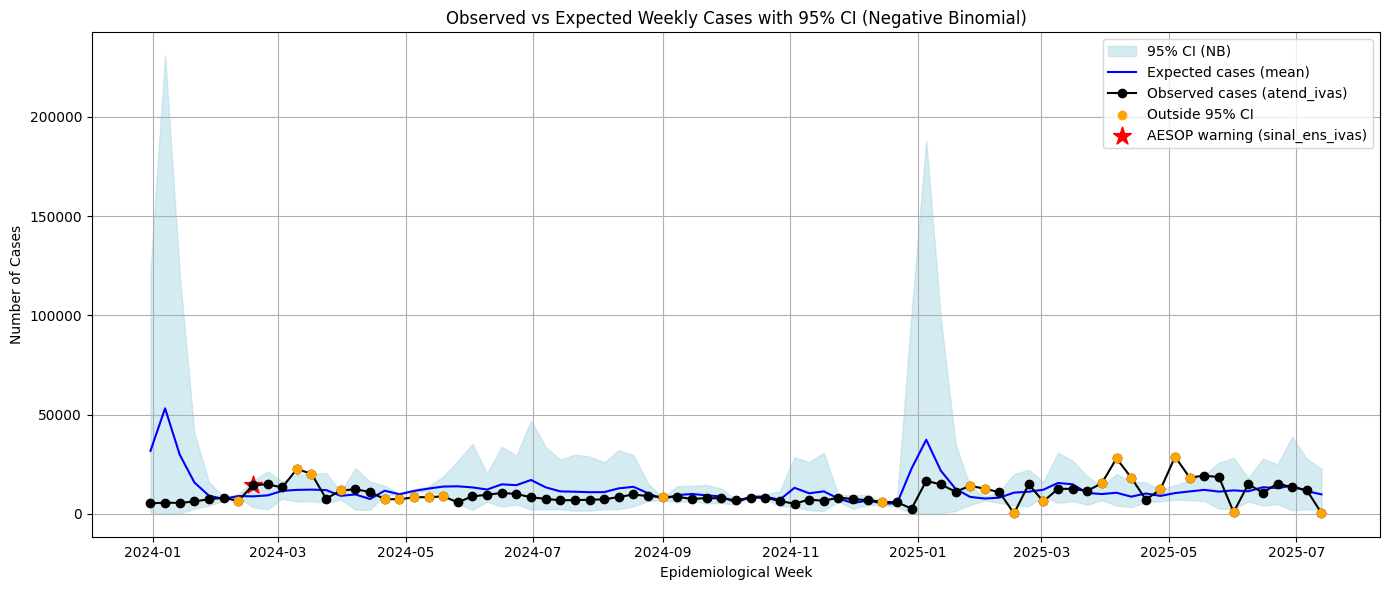

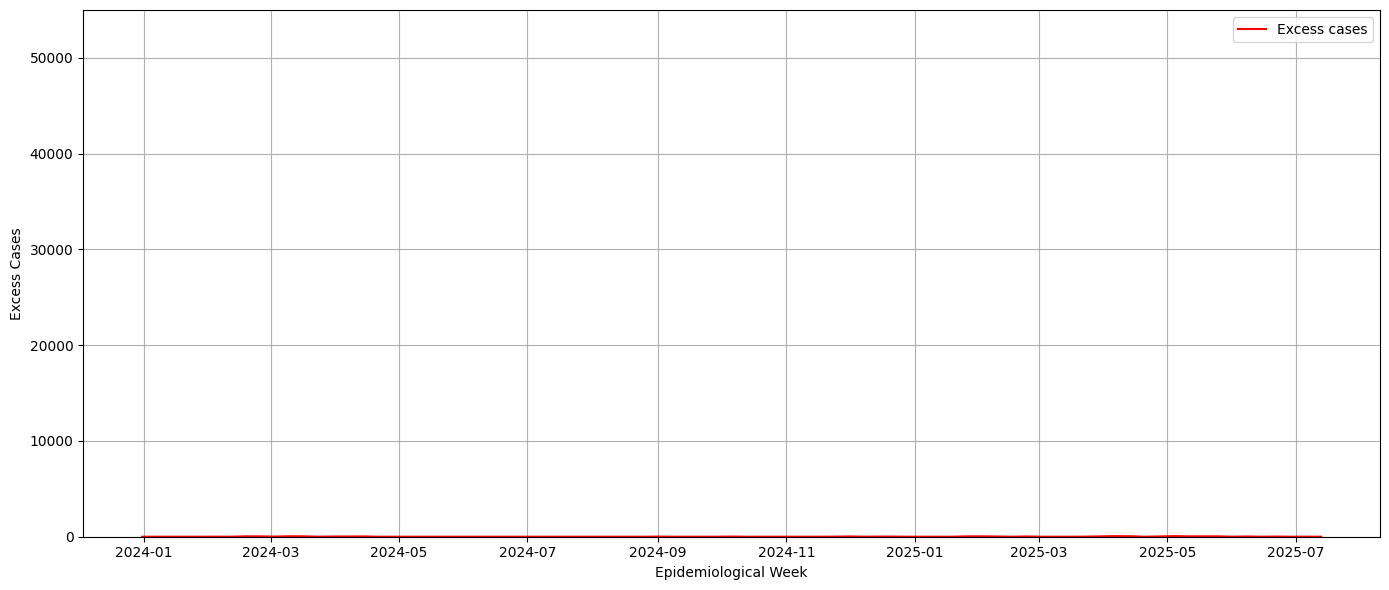

In [14]:
set_muni['epidemi_cal_start'] = pd.to_datetime(set_muni['epidemi_cal_start'])

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval
plt.fill_between(set_muni['epidemi_cal_start'], set_muni['ci_lower_95_atend_ivas'], set_muni['ci_upper_95_atend_ivas'],
                 color='lightblue', alpha=0.5, label='95% CI (NB)')

# Expected cases
plt.plot(set_muni['epidemi_cal_start'], set_muni['expected_atend_ivas'], color='blue', label='Expected cases (mean)')

# Observed cases
plt.plot(set_muni['epidemi_cal_start'], set_muni['atend_ivas'], color='black', marker='o', label='Observed cases (atend_ivas)')

# Highlight points outside CI
outside_ci = (set_muni['atend_ivas'] < set_muni['ci_lower_95_atend_ivas']) | (set_muni['atend_ivas'] > set_muni['ci_upper_95_atend_ivas'])
plt.scatter(set_muni.loc[outside_ci, 'epidemi_cal_start'],
            set_muni.loc[outside_ci, 'atend_ivas'],
            color='orange', label='Outside 95% CI', zorder=5)

# Orange stars for sinal_aesop_ivas == 1
warning_weeks = set_muni[set_muni['sinal_ens_ivas'] == 1]
plt.scatter(warning_weeks['epidemi_cal_start'], warning_weeks['atend_ivas'],
            color='red', marker='*', s=180, label='AESOP warning (sinal_ens_ivas)') #edgecolor='darkred'

#plt.ylim([0, 10000])
# Labels
plt.xlabel('Epidemiological Week')
plt.ylabel('Number of Cases')
plt.title('Observed vs Expected Weekly Cases with 95% CI (Negative Binomial)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(14, 6))

# Excess cases
plt.plot(set_muni['epidemi_cal_start'], set_muni['exc_atend_ivas'], color='red', label='Excess cases')


plt.ylim([0, 55000])
# Labels
plt.xlabel('Epidemiological Week')
plt.ylabel('Excess Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


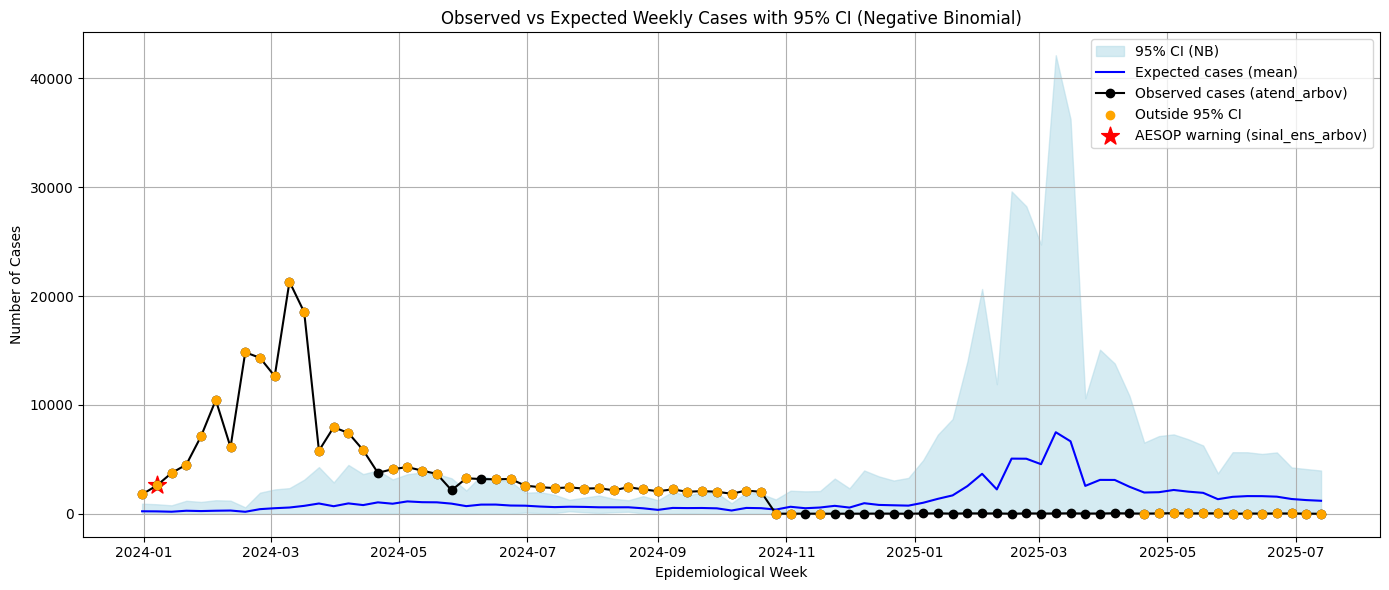

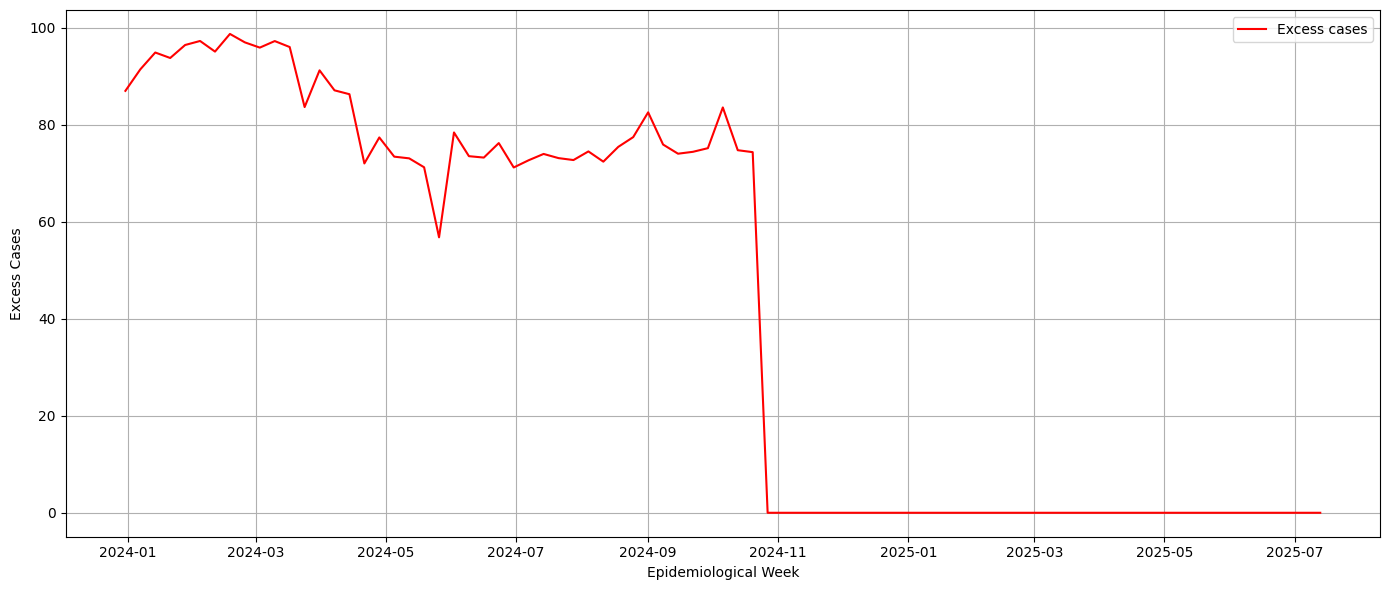

In [15]:
set_muni['epidemi_cal_start'] = pd.to_datetime(set_muni['epidemi_cal_start'])

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval
plt.fill_between(set_muni['epidemi_cal_start'], set_muni['ci_lower_95_atend_arbov'], set_muni['ci_upper_95_atend_arbov'],
                 color='lightblue', alpha=0.5, label='95% CI (NB)')

# Expected cases
plt.plot(set_muni['epidemi_cal_start'], set_muni['expected_atend_arbov'], color='blue', label='Expected cases (mean)')

# Observed cases
plt.plot(set_muni['epidemi_cal_start'], set_muni['atend_arbov'], color='black', marker='o', label='Observed cases (atend_arbov)')

# Highlight points outside CI
outside_ci = (set_muni['atend_arbov'] < set_muni['ci_lower_95_atend_arbov']) | (set_muni['atend_arbov'] > set_muni['ci_upper_95_atend_arbov'])
plt.scatter(set_muni.loc[outside_ci, 'epidemi_cal_start'],
            set_muni.loc[outside_ci, 'atend_arbov'],
            color='orange', label='Outside 95% CI', zorder=5)

# Orange stars for sinal_aesop_ivas == 1
warning_weeks = set_muni[set_muni['sinal_ens_arbov'] == 1]
plt.scatter(warning_weeks['epidemi_cal_start'], warning_weeks['atend_arbov'],
            color='red', marker='*', s=180, label='AESOP warning (sinal_ens_arbov)') #edgecolor='darkred'

#plt.ylim([0, 10000])
# Labels
plt.xlabel('Epidemiological Week')
plt.ylabel('Number of Cases')
plt.title('Observed vs Expected Weekly Cases with 95% CI (Negative Binomial)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(14, 6))

# Excess cases
plt.plot(set_muni['epidemi_cal_start'], set_muni['exc_atend_arbov'], color='red', label='Excess cases')


#plt.ylim([0, 10000])
# Labels
plt.xlabel('Epidemiological Week')
plt.ylabel('Excess Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
df_final2.to_parquet('/home/juliane.oliveira/workspace/Data/data_29_07_2025.parquet')

In [22]:
df_final2.columns.to_list()

['co_ibge',
 'epiyear',
 'epiweek',
 'atend_totais',
 'atend_ivas',
 'atend_arbov',
 'year_week',
 'co_uf',
 'nm_uf',
 'co_ibge7',
 'nm_municipio',
 'sigla_uf',
 'epidemi_cal_start',
 'epidemi_cal_end',
 'perc_missing',
 'perc_completude',
 'diff_2w',
 'diff_3w',
 'sum_miss',
 'completude',
 'tempestividade',
 'dqi',
 'sinal_ears_ivas',
 'lim_esp_ears_ivas',
 'prob_gro_trend_ivas',
 'lim_esp_mmaing_ivas',
 'sinal_mmaing_ivas',
 'sinal_ears_arbov',
 'lim_esp_ears_arbov',
 'prob_gro_trend_arbov',
 'num_otc_ivas',
 'lim_esp_otc_ivas',
 'sinal_otc_ivas',
 'lim_esp_evi_ivas',
 'sinal_evi_ivas',
 'exc_evi_ivas',
 'lim_esp_evi_arbov',
 'sinal_evi_arbov',
 'exc_evi_arbov',
 'pop',
 'year_week_ts',
 'ra_atend_ivas',
 'ra_atend_ivas_ma',
 'gr_ra_atend_ivas_ma',
 'ra_atend_arbov',
 'ra_atend_arbov_ma',
 'gr_ra_atend_arbov_ma',
 'sinal_ens_ivas',
 'sinal_ens_arbov',
 'lim_esp_ens_ivas',
 'lim_esp_ens_arbov',
 'alerta_vizinho',
 'sinais_vizinhos',
 'sinal_aesop_ivas',
 'co_reg_saude',
 'nm_reg_saud

In [23]:
lst = ['co_ibge',
 'epiyear',
 'epiweek',
 'atend_totais',
 'atend_ivas',
 'atend_totais',
 'year_week',
 'co_uf',
 'nm_uf',
 'co_ibge7',
 'nm_municipio',
 'sigla_uf',
 'epidemi_cal_start',
 'epidemi_cal_end',
 'dqi',
 'prob_gro_trend_ivas',
 'sinal_ears_ivas',
 'lim_esp_ears_ivas',
 'sinal_ears_ivas_y',
 'sinal_ens_ivas',
 'lim_esp_ens_ivas',
 'sinal_ens_ivas_y',
 ]

In [28]:
test = df_final2[lst][df_final2.year_week >= '2022-42']

In [32]:
test[test.sinal_ens_ivas_y == 0.5][['co_ibge','year_week', 'lim_esp_ens_ivas','sinal_ens_ivas',
 'sinal_ens_ivas_y']]

,co_ibge,year_week,lim_esp_ens_ivas,sinal_ens_ivas,sinal_ens_ivas_y
312,110001,2022-52,97.0,0,0.5
326,110001,2023-14,40.0,0,0.5
329,110001,2023-17,59.0,0,0.5
337,110001,2023-25,60.0,0,0.5
339,110001,2023-27,57.0,0,0.5
...,...,...,...,...,...
2484202,530010,2025-12,9525.0,0,0.5
2484203,530010,2025-13,10257.0,0,0.5
2484205,530010,2025-15,12350.0,0,0.5
2484208,530010,2025-18,8893.0,0,0.5


In [31]:
test[['co_ibge','year_week', 'lim_esp_ens_ivas','sinal_ens_ivas',
 'sinal_ens_ivas_y']]

,co_ibge,year_week,lim_esp_ens_ivas,sinal_ens_ivas,sinal_ens_ivas_y
302,110001,2022-42,29.0,1,1.0
303,110001,2022-43,26.0,0,0.0
304,110001,2022-44,25.0,0,0.0
305,110001,2022-45,25.0,1,1.0
306,110001,2022-46,34.0,1,1.0
...,...,...,...,...,...
2484215,530010,2025-25,15564.0,0,0.0
2484216,530010,2025-26,16146.0,0,0.0
2484217,530010,2025-27,17272.0,0,0.0
2484218,530010,2025-28,16462.0,0,0.0
